## Regression Discontinuity Design (RDD) for the $100 Loyalty Campaign

**Project objective**:

Evaluate whether the loyalty campaign for customers spending > $100/week increases future spending.
No A/B test was run, so we use Regression Discontinuity Design (RDD).

### What is RDD and why use it
**Design**: Quasi-experimental method for programs with an eligibility cutoff.

**Running variable**: Weekly spend.

**Cutoff**: $100.

**Treatment**: campaign exposure if spend > 100.

**Identification**: Compare users just below vs just above the cutoff to estimate the local treatment effect.

**Why close to RCT**: Near the threshold, treated and control units are similar in observed and unobserved factors except for treatment receipt.

### Assumptions

1. The running variable is continuous at the cutoff.
2. No precise manipulation of eligibility at the threshold.
3. Potential outcomes are smooth in the running variable at the cutoff.

We will visualize the running variable density and outcome around the cutoff as informal checks.

### Setup, data simulation, and DataFrame
This block reproduces the article's simulation: 1,000 customers with normally distributed weekly spend, sharp treatment assignment at $100, and a positive treatment effect on future spending.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

pd.options.mode.copy_on_write = True

# Simulate customer data
np.random.seed(42)

# Number of customers
n_customers = 1000

# Simulating customer spending with random values
spending = np.random.normal(100, 25, n_customers)

# Treatment assignment (1 if spending > 100, 0 otherwise)
treatment = (spending > 100).astype(int)

# Simulating an outcome variable (e.g., future spending) based on treatment effect
# The treatment is expected to have a positive effect on future spending
future_spending = spending + 25 * treatment + np.random.normal(0, 15, n_customers)  # Adding noise to future spending

# Creating a DataFrame
data = pd.DataFrame({
    'customer_id': range(1, n_customers + 1),
    'spending': spending,
    'treatment': treatment,
    'future_spending': future_spending
})

### Visualizing the discontinuity
The scatter below shows future spending vs weekly spend with a vertical line at the $100 threshold.
A visible jump at the cutoff is consistent with a treatment effect.

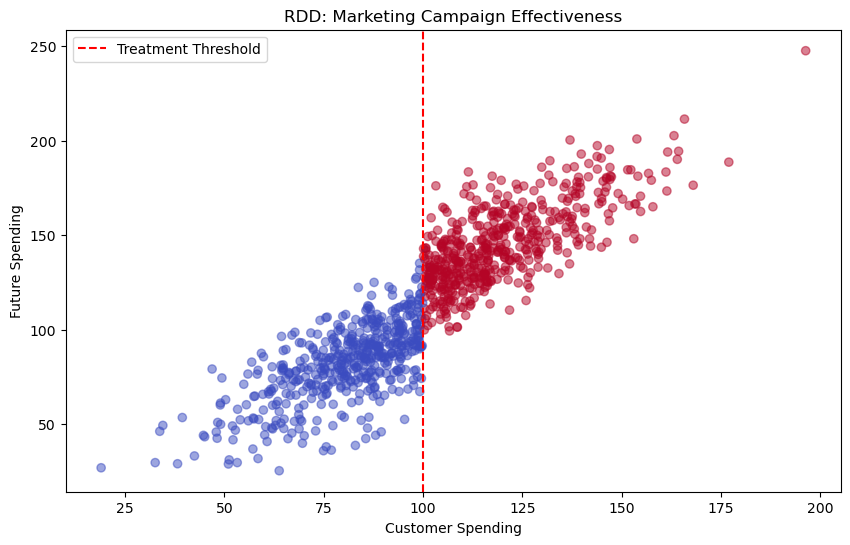

In [22]:
# Plotting the data to visualize the discontinuity
plt.figure(figsize=(10, 6))
plt.scatter(data['spending'], data['future_spending'], c=data['treatment'], cmap='coolwarm', alpha=0.5)
plt.axvline(x=100, color='red', linestyle='--', label='Treatment Threshold')
plt.title('RDD: Marketing Campaign Effectiveness')
plt.xlabel('Customer Spending')
plt.ylabel('Future Spending')
plt.legend()
plt.show()

### Piecewise linear trends on each side of the cutoff
We fit separate OLS lines left and right of the threshold to visualize the level shift.
This is descriptive and not yet the formal local-linear RDD.

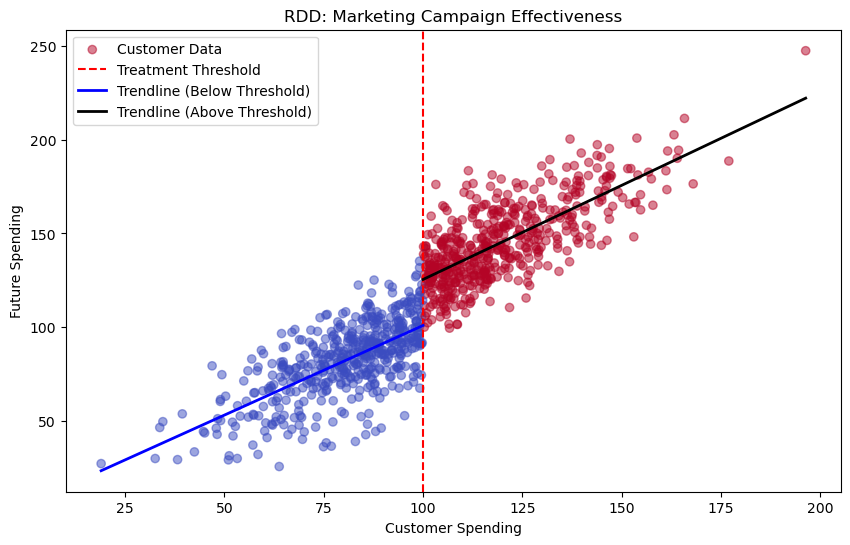

In [23]:
# Fit linear regression models for the data on both sides of the cutoff
left_data = data[data['spending'] <= 100]
right_data = data[data['spending'] > 100]

# Create the X and Y arrays for each side (including constant for intercept)
X_left = sm.add_constant(left_data['spending'])
y_left = left_data['future_spending']

X_right = sm.add_constant(right_data['spending'])
y_right = right_data['future_spending']

# Fit the regression models
model_left = sm.OLS(y_left, X_left).fit()
model_right = sm.OLS(y_right, X_right).fit()

# Create a range of spending values for plotting the trendlines
spending_range_left = np.linspace(left_data['spending'].min(), 100, 100)
spending_range_right = np.linspace(100, right_data['spending'].max(), 100)

# Predict the future spending based on the regression models
pred_left = model_left.predict(sm.add_constant(spending_range_left))
pred_right = model_right.predict(sm.add_constant(spending_range_right))

# Plotting the data and the trendlines
plt.figure(figsize=(10, 6))
plt.scatter(data['spending'], data['future_spending'], c=data['treatment'], cmap='coolwarm', alpha=0.5, label='Customer Data')
plt.axvline(x=100, color='red', linestyle='--', label='Treatment Threshold')

# Plot the trendlines
plt.plot(spending_range_left, pred_left, color='blue', label='Trendline (Below Threshold)', linewidth=2)
plt.plot(spending_range_right, pred_right, color='black', label='Trendline (Above Threshold)', linewidth=2)

plt.title('RDD: Marketing Campaign Effectiveness')
plt.xlabel('Customer Spending')
plt.ylabel('Future Spending')
plt.legend()
plt.show()

### Local-linear RDD within a bandwidth of ±5 around the cutoff
We estimate the jump at the cutoff using observations with spend ∈ [95, 105].
The running variable is centered at 100. The OLS is a simple local linear approximation.

In [24]:
# Define a bandwidth around the cutoff (we'll use a small bandwidth to focus on the discontinuity)
bandwidth = 5

# Selecting data within the bandwidth of the cutoff
data_rdd = data[(data['spending'] >= 100 - bandwidth) & (data['spending'] <= 100 + bandwidth)]

# Create the running variable centered around the cutoff (spending - 100)
data_rdd['running_var'] = data_rdd['spending'] - 100

# Adding constant for the intercept in the regression model
X = sm.add_constant(data_rdd['running_var'])
y = data_rdd['future_spending']

# Fit the regression model (we will fit a linear model to each side of the cutoff)
model = sm.OLS(y, X).fit()

# Display the summary of the regression model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        future_spending   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     117.0
Date:                Tue, 30 Sep 2025   Prob (F-statistic):           1.23e-20
Time:                        23:58:27   Log-Likelihood:                -651.78
No. Observations:                 156   AIC:                             1308.
Df Residuals:                     154   BIC:                             1314.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         113.8362      1.285     88.591      0.000     111.298     116.375
running_var     5.0010      0.462     10.816      0.000       4.088       5.915
==============================================================================
Omnibus:                        0.259   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.879   Jarque-Bera (JB):                0.252
Skew:                          -0.094   Prob(JB):                        0.882
Kurtosis:                       2.940   Cond. No.                         2.82
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Interpretation**: The intercept approximates expected future spending at the cutoff from the left.

To recover the treatment jump formally, include treatment and its interaction with the centered running variable.


### Boxplot near the cutoff
Distributional comparison of future spending by treatment status within ±5 of the cutoff.

<Figure size 1000x600 with 0 Axes>

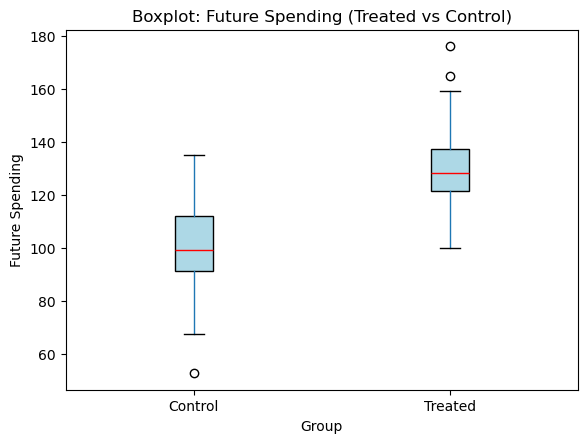

In [25]:
plt.figure(figsize=(10, 6))
data_rdd.boxplot(column='future_spending', by='treatment', grid=False, patch_artist=True, 
                 boxprops=dict(facecolor='lightblue', color='black'), medianprops=dict(color='red'))
plt.title('Boxplot: Future Spending (Treated vs Control)')
plt.suptitle('')
plt.xlabel('Group')
plt.ylabel('Future Spending')
plt.xticks([1, 2], ['Control', 'Treated'])
plt.show()

### Cumulative distributions near the cutoff
Empirical CDFs for treated vs control within the analysis window.
Rightward shift of the treated CDF indicates higher outcomes across the distribution.


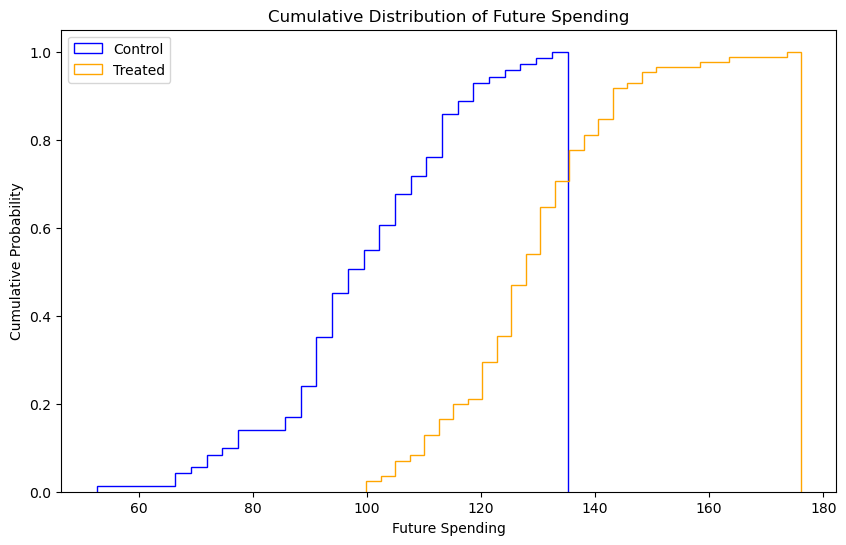

In [26]:
from scipy.stats import cumfreq

# Cumulative distributions
control = data_rdd[data_rdd['running_var'] < 0]['future_spending']
treated = data_rdd[data_rdd['running_var'] >= 0]['future_spending']

plt.figure(figsize=(10, 6))
plt.hist(control, bins=30, density=True, cumulative=True, histtype='step', color='blue', label='Control')
plt.hist(treated, bins=30, density=True, cumulative=True, histtype='step', color='orange', label='Treated')

plt.title('Cumulative Distribution of Future Spending')
plt.xlabel('Future Spending')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()

### Caution and scope
- RDD identifies a local effect at the cutoff; do not generalize far from $100 without more work.
- If business decisions involve expanding or shrinking eligibility at the margin, this LATE is decision-relevant.
- Add manipulation checks and covariate continuity tests when real data are available.

### Optional extension: formal sharp RDD with treatment and interaction
This variant estimates the treatment jump explicitly with treatment and its interaction.
Use heteroskedasticity-robust SEs and try multiple bandwidths.

In [27]:
def sharp_rdd(df, cutoff=100, bandwidth=10):
    d = df[(df['spending'] >= cutoff - bandwidth) & (df['spending'] <= cutoff + bandwidth)].copy()
    d['Xc'] = d['spending'] - cutoff
    d['DxXc'] = d['treatment'] * d['Xc']
    X = sm.add_constant(d[['treatment','Xc','DxXc']])
    y = d['future_spending']
    m = sm.OLS(y, X).fit(cov_type='HC1')
    return m

for bw in [5, 10, 20]:
    print(f"\n=== Bandwidth ±{bw} ===")
    m = sharp_rdd(data, bandwidth=bw)
    print(m.summary().tables[1])



=== Bandwidth ±5 ===
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.0927      3.700     28.135      0.000      96.841     111.344
treatment     21.8754      4.695      4.659      0.000      12.673      31.078
Xc             2.0380      1.489      1.369      0.171      -0.880       4.956
DxXc          -0.7347      1.815     -0.405      0.686      -4.291       2.822

=== Bandwidth ±10 ===
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        102.8185      2.505     41.051      0.000      97.909     107.727
treatment     23.7695      3.249      7.317      0.000      17.402      30.137
Xc             1.3986      0.433      3.227      0.001       0.549       2.248
DxXc          -0.6607      0.566     -1.168      0.243      -1.770       0.448

=== Ba

**Interpretation**

- Across all bandwidths, the estimated treatment effect is consistently ~22–24 additional dollars in future spending.
- Baseline spending at the cutoff is about $100–104, so the uplift is roughly 20–23%.
- The result is statistically strong (p < 0.001) and stable across bandwidth choices.
- Slopes (Xc, DxXc) are not significant at ±5 and ±10, but become more precisely estimated at ±20 due to more data.
- No evidence of slope discontinuity (the effect comes from the intercept jump).

### Conclusion
The regression discontinuity analysis shows a clear and consistent causal uplift from the loyalty campaign:
- Customers just above the $100/week cutoff spend about $22–24 more in future weeks than nearly identical customers just below it.
- This translates to an uplift of roughly 20–23% relative to the baseline at the cutoff.
- The effect is stable across bandwidths (±5, ±10, ±20), highly statistically significant, and visually supported by the discontinuity plots.
- The gain appears to come from a level shift at the cutoff rather than slope changes.

**Implication for leadership**:
The campaign is effective for marginally loyal customers (those at the cutoff). If the per-user cost of the campaign is less than the margin earned on ~$23 incremental spend, the program is ROI-positive at the margin.

**Limitations**:
RDD identifies a local average treatment effect only; it does not guarantee the same uplift for customers with much higher or lower weekly spend.
Manipulation tests and covariate continuity checks should be performed on real data.

**Bottom line**:
The campaign works for customers near the $100 eligibility threshold, delivering a sizable and robust increase in future spending. It is a worthwhile intervention at the margin.